In [80]:
# Call the relevant python packages
import numpy as np
import pandas as pd
import glob, os                          # Operating system module and pathnames

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord


# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Output plots in Notebook
#%matplotlib notebook
%matplotlib inline  

# Table Setup

In [142]:
# Read in the catalogue

file = 'NGC6822_Full_Statistics.csv'
data = ascii.read(file, data_start=1)


#create indices for any sensible sources that meet the numbered conditions
c1_idx=np.where(data['c1']>0)
c2_idx=np.where(data['c2']>0)
c3_idx=np.where(data['c3']>0)
c4_idx=np.where(data['c4']>0)
c5_idx=np.where(data['c5']>0)
c6_idx=np.where(data['c6']>0)
c7_idx=np.where(data['c7']>0)
c8_idx=np.where(data['c8']>0)
c9_idx=np.where(data['c9']>0)

#create columns for all stars having met the conditions
data['c2 met?']=0
data['c3 met?']=0
data['c4 met?']=0
data['c5 met?']=0
data['c6 met?']=0
data['c9 met?']=0
data['sp rel?']=0
data['HJK rel?']=0
data['YSO Score Spitzer']=0
data['YSO Score HJK']=0

def write_column(crit,name):
    print("Number of stars in cut "+name+": {}".format(len(crit[0])))
    for i in range(len(crit[0])):
        #writes '1' to cell where condition is met
        #'0' is the default
        data[name][crit[0][i]]=1

def write_column_append(crit,name):
    print("Number of stars in cut "+name+": {}".format(len(crit[0])))
    for i in range(len(crit[0])):
        #adds '1' to cell where condition is met
        data[name][crit[0][i]]+=1


write_column(c2_idx,'c2 met?')
write_column(c3_idx,'c3 met?')
write_column(c4_idx,'c4 met?')
write_column(c5_idx,'c5 met?')
write_column(c6_idx,'c6 met?')
write_column(c9_idx,'c9 met?')

Number of stars in cut c2 met?: 1533
Number of stars in cut c3 met?: 5181
Number of stars in cut c4 met?: 1415
Number of stars in cut c5 met?: 2092
Number of stars in cut c6 met?: 766
Number of stars in cut c9 met?: 667


In [82]:
#print column names
data.colnames

['ID',
 'RA',
 'Dec',
 'k36mag',
 'e36mag',
 'd36mag',
 'k45mag',
 'e45mag',
 'd45mag',
 'k58mag',
 'e58mag',
 'd58mag',
 'k80mag',
 'e80mag',
 'd80mag',
 'k24mag',
 'e24mag',
 'dstArcSec',
 'RAJ2000',
 'DEJ2000',
 'Jmag',
 'eJmag',
 'Hmag',
 'eHmag',
 'Kmag',
 'eKmag',
 'c1a',
 'c1b',
 'c1c',
 'c2a',
 'c2b',
 'c2c',
 'c3a',
 'c3b',
 'c3c',
 'c4a',
 'c4b',
 'c5a',
 'c5b',
 'c5c',
 'c6a',
 'c6b',
 'c6c',
 'c7',
 'c8',
 'c9a',
 'c9b',
 'c9c',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c9',
 '24 data?',
 '36 data?',
 '45 data?',
 '58 data?',
 '80 data?',
 'SpNum',
 'H data?',
 'J data?',
 'K data?',
 'HJKNum',
 'c2 met?',
 'c3 met?',
 'c4 met?',
 'c5 met?',
 'c6 met?',
 'c9 met?',
 'sp rel?',
 'HJK rel?',
 'YSO Score Spitzer',
 'YSO Score HJK']

In [143]:
# Create catalogues of reliable sources
#reliable Spitzer is 3,4 or 5 out of 5
#reliable HJK is 2,3 out of 3

reliable_sp_idx=((data['SpNum']>=3))
reliable_sp_cat=data[reliable_sp_idx]
# write a column containing 1 if the source is reliable in Spitzer terms
write_column(np.where(reliable_sp_idx),'sp rel?')

#selects reliable spitzer sources
idx_sp_rel=np.where(data['sp rel?']==1)




reliable_HJK_idx=((data['HJKNum']>=2) & (data['45 data?']==1) & (data['36 data?']==1))
reliable_HJK_cat=data[reliable_HJK_idx]
# write a column containing 1 if the source is reliable in HJK terms
write_column(np.where(reliable_HJK_idx),'HJK rel?')

#selects reliable HJK sources
idx_HJK_rel=np.where(data['HJK rel?']==1)

#uncomment below to view the reliable Spitzer and HJK catalogues
#reliable_sp_cat.show_in_browser(jsviewer=True)
#reliable_HJK_cat.show_in_browser(jsviewer=True)

Number of stars in cut sp rel?: 26273
Number of stars in cut HJK rel?: 14247


In [144]:
#YSO Score

data['YSO Score Spitzer'][idx_sp_rel]=data['c2 met?'][idx_sp_rel]+data['c3 met?'][idx_sp_rel]+data['c4 met?'][idx_sp_rel]+data['c5 met?'][idx_sp_rel]+data['c6 met?'][idx_sp_rel]+data['c9 met?'][idx_sp_rel]
#find how many have each score
#note that having a score of 0 out of 6 can be due to a source not being reliable, but reliable sources will
#also get a score of 0 if they do not appear in any of the CMDs
idx_sp_YSO_score_0=np.where(data['YSO Score Spitzer']==0)
print("The number of stars with a YSO Spitzer score of 0 out of 6 is "+str(len(idx_sp_YSO_score_0[0])))
idx_sp_YSO_score_1=np.where(data['YSO Score Spitzer']==1)
print("The number of reliable stars with a YSO Spitzer score of 1 out of 6 is "+str(len(idx_sp_YSO_score_1[0])))
idx_sp_YSO_score_2=np.where(data['YSO Score Spitzer']==2)
print("The number of reliable stars with a YSO Spitzer score of 2 out of 6 is "+str(len(idx_sp_YSO_score_2[0])))
idx_sp_YSO_score_3=np.where(data['YSO Score Spitzer']==3)
print("The number of reliable stars with a YSO Spitzer score of 3 out of 6 is "+str(len(idx_sp_YSO_score_3[0])))
idx_sp_YSO_score_4=np.where(data['YSO Score Spitzer']==4)
print("The number of reliable stars with a YSO Spitzer score of 4 out of 6 is "+str(len(idx_sp_YSO_score_4[0])))
idx_sp_YSO_score_5=np.where(data['YSO Score Spitzer']==5)
print("The number of reliable stars with a YSO Spitzer score of 5 out of 6 is "+str(len(idx_sp_YSO_score_5[0])))
idx_sp_YSO_score_6=np.where(data['YSO Score Spitzer']==6)
print("The number of reliable stars with a YSO Spitzer score of 6 out of 6 is "+str(len(idx_sp_YSO_score_6[0])))

data['YSO Score HJK'][idx_HJK_rel]=data['c2 met?'][idx_HJK_rel]+data['c3 met?'][idx_HJK_rel]+data['c4 met?'][idx_HJK_rel]+data['c5 met?'][idx_HJK_rel]+data['c6 met?'][idx_HJK_rel]+data['c9 met?'][idx_HJK_rel]
#find how many have each score
#note that having a score of 0 out of 6 can be due to a source not being reliable, but reliable sources will
#also get a score of 0 if they do not appear in any of the CMDs
idx_HJK_YSO_score_0=np.where(data['YSO Score HJK']==0)
print("The number of stars with a YSO HJK score of 0 out of 6 is "+str(len(idx_HJK_YSO_score_0[0])))
idx_HJK_YSO_score_1=np.where(data['YSO Score HJK']==1)
print("The number of reliable stars with a YSO HJK score of 1 out of 6 is "+str(len(idx_HJK_YSO_score_1[0])))
idx_HJK_YSO_score_2=np.where(data['YSO Score HJK']==2)
print("The number of reliable stars with a YSO HJK score of 2 out of 6 is "+str(len(idx_HJK_YSO_score_2[0])))
idx_HJK_YSO_score_3=np.where(data['YSO Score HJK']==3)
print("The number of reliable stars with a YSO HJK score of 3 out of 6 is "+str(len(idx_HJK_YSO_score_3[0])))
idx_HJK_YSO_score_4=np.where(data['YSO Score HJK']==4)
print("The number of reliable stars with a YSO HJK score of 4 out of 6 is "+str(len(idx_HJK_YSO_score_4[0])))
idx_HJK_YSO_score_5=np.where(data['YSO Score HJK']==5)
print("The number of reliable stars with a YSO HJK score of 5 out of 6 is "+str(len(idx_HJK_YSO_score_5[0])))
idx_HJK_YSO_score_6=np.where(data['YSO Score HJK']==6)
print("The number of reliable stars with a YSO HJK score of 6 out of 6 is "+str(len(idx_HJK_YSO_score_6[0])))

The number of stars with a YSO Spitzer score of 0 out of 6 is 23431
The number of reliable stars with a YSO Spitzer score of 1 out of 6 is 5553
The number of reliable stars with a YSO Spitzer score of 2 out of 6 is 920
The number of reliable stars with a YSO Spitzer score of 3 out of 6 is 313
The number of reliable stars with a YSO Spitzer score of 4 out of 6 is 213
The number of reliable stars with a YSO Spitzer score of 5 out of 6 is 160
The number of reliable stars with a YSO Spitzer score of 6 out of 6 is 155
The number of stars with a YSO HJK score of 0 out of 6 is 27980
The number of reliable stars with a YSO HJK score of 1 out of 6 is 2201
The number of reliable stars with a YSO HJK score of 2 out of 6 is 354
The number of reliable stars with a YSO HJK score of 3 out of 6 is 82
The number of reliable stars with a YSO HJK score of 4 out of 6 is 47
The number of reliable stars with a YSO HJK score of 5 out of 6 is 40
The number of reliable stars with a YSO HJK score of 6 out of 6 

In [145]:
#Create reliable catalogues for reliably-scored sources
reliable_sp_score_idx=((data['YSO Score Spitzer']>=3))
idx_rel_sp_score=np.where(data['YSO Score Spitzer']>=3)
reliable_sp_score_cat=data[reliable_sp_score_idx]
#reliable_sp_score_cat.show_in_browser(jsviewer=True)
print("The number of sources in the reliably-scored Spitzer catalogue is "+str(len(np.where(reliable_sp_score_idx)[0])))

reliable_HJK_score_idx=((data['YSO Score HJK']>=3))
idx_rel_HJK_score=np.where(data['YSO Score HJK']>=3)
reliable_HJK_score_cat=data[reliable_HJK_score_idx]
#reliable_HJK_score_cat.show_in_browser(jsviewer=True)
print("The number of sources in the reliably-scored HJK catalogue is "+str(len(np.where(reliable_HJK_score_idx)[0])))


#Create unreliable catalogue for unreliably-scored sources
unreliable_score_idx=((data['YSO Score Spitzer']<3) & (data['YSO Score HJK']<3))
unreliable_score_cat=data[unreliable_score_idx]
#unreliable_score_cat.show_in_browser(jsviewer=True)
print("The number of sources in the unreliably-scored catalogue is "+str(len(np.where(unreliable_score_idx)[0])))

#unreliable_HJK_score_idx=((data['YSO Score HJK']<=3))
#unreliable_HJK_score_cat=data[unreliable_HJK_score_idx]
#unreliable_HJK_score_cat.show_in_browser(jsviewer=True)
#print("The number of sources in the unreliably-scored HJK catalogue is "+str(len(np.where(unreliable_HJK_score_idx)[0])))


The number of sources in the reliably-scored Spitzer catalogue is 841
The number of sources in the reliably-scored HJK catalogue is 210
The number of sources in the unreliably-scored catalogue is 29904


In [110]:
# If you want to examine the catalogue in browser
data.show_in_browser(jsviewer=True)

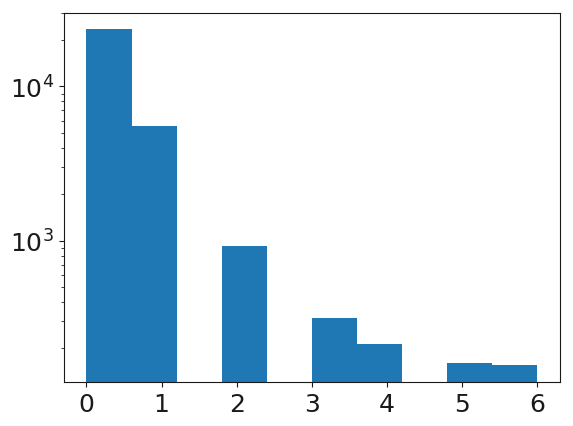

In [146]:
# Score histograms

data['YSO Score Spitzer'] = data['YSO Score Spitzer'].astype(int)
hist_sp=plt.hist(data['YSO Score Spitzer'],align='mid')
plt.yscale("log")

sns.set(); np.random.seed(0)
data['YSO Score Spitzer'] = data['YSO Score Spitzer'].astype(int)
hist_array_sp=data['YSO Score Spitzer']
#ax = sns.distplot(hist_array_sp)

sns.set(); np.random.seed(0)
data['YSO Score HJK'] = data['YSO Score HJK'].astype(int)
hist_array_sHJK=data['YSO Score HJK']
#ax = sns.distplot(hist_array_HJK)

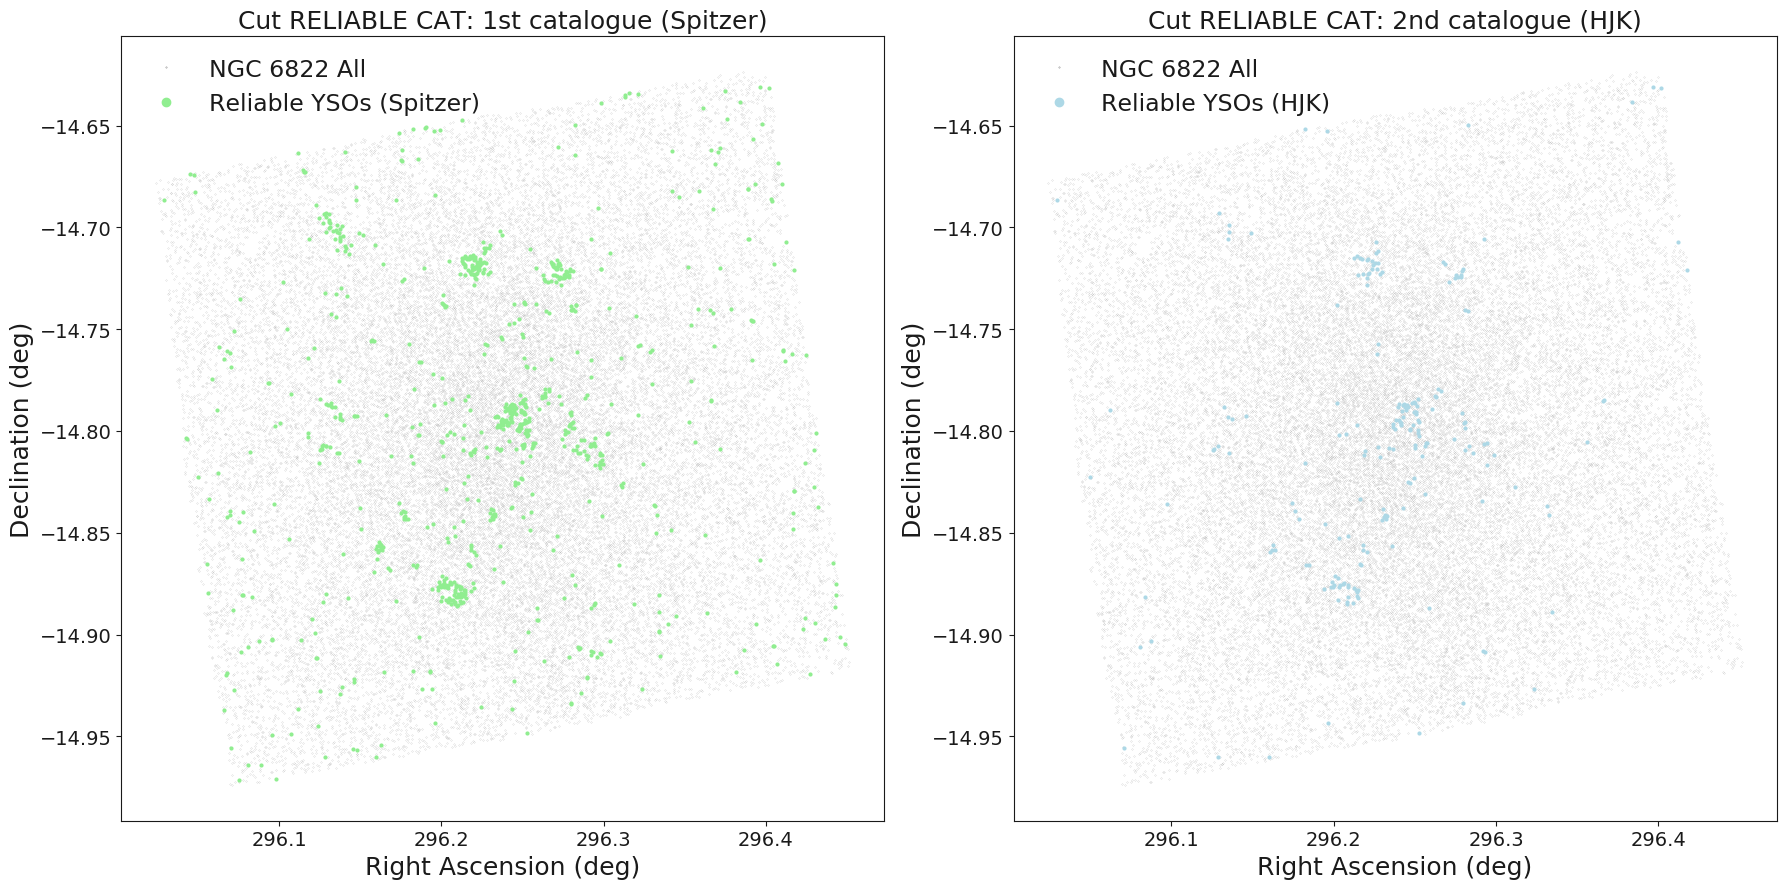

In [147]:
#Location plots
def location_plot(sp_idx,HJK_idx,num):
    # Plot the cataloge data on the sky
    # Setting up plotting sizes
    # plt.rc("text",  usetex=True)         # Allows latex commands
    plt.rcParams.update(plt.rcParamsDefault)       #Keeps the background white
    plt.rc('font', family='sans-serif')
    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.rc("axes", labelsize=14)
    plt.rc("legend", fontsize=17)
    # plt.rcdefaults()                    # Resets the parameters to their default values
    
    
    # Setting up figure
    plt.figure(figsize=(18,9))
    ax = plt.gca()                        # Sets up active plot region
    
    #Make 1st diagram for 1st reliable catalogue
    plt.subplot(1,2,1)
    # Make the actual plot
    plt.plot(data['RA'], data['Dec'], '.', color='grey', ms=0.2, label="NGC 6822 All")
    
    #Over plot sensible sources which make the colour cut criteria
    #plt.plot(data['RA'][all_idx], data['Dec'][all_idx], '.', color='darkviolet', ms=4, label="YSO candidates")
    
    #overplot all reliable sources that meet the cut
    plt.plot(data['RA'][sp_idx], data['Dec'][sp_idx], '.', color='lightgreen', ms=4, label="Reliable YSOs (Spitzer)")
    
    plt.xlabel('Right Ascension (deg)', size=18)
    plt.ylabel('Declination (deg)', size=18)
    
    # Add a legend and a title
    plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title('Cut '+num+': 1st catalogue (Spitzer)',fontsize=18)
    
    #Make 2nd diagram for 2nd reliable catalogue
    plt.subplot(1,2,2)
    # Make the actual plot
    plt.plot(data['RA'], data['Dec'], '.', color='grey', ms=0.2, label="NGC 6822 All")
    
    #Over plot sensible sources which make the colour cut criteria
    #plt.plot(data['RA'][all_idx], data['Dec'][all_idx], '.', color='darkviolet', ms=4, label="YSO candidates")
    
    plt.plot(data['RA'][HJK_idx], data['Dec'][HJK_idx], '.', color='lightblue', ms=4, label="Reliable YSOs (HJK)")
    
    plt.xlabel('Right Ascension (deg)', size=18)
    plt.ylabel('Declination (deg)', size=18)
    
    # Add a legend and a title
    plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title('Cut '+num+': 2nd catalogue (HJK)',fontsize=18)
    
    #plt.savefig("bla.pdf", bbox_inches='tight')    # Saves the figure is uncommented
    plt.tight_layout()
    plt.show()
    plt.close()
    
location_plot(idx_rel_sp_score,idx_rel_HJK_score,'RELIABLE CAT')

# CMDs

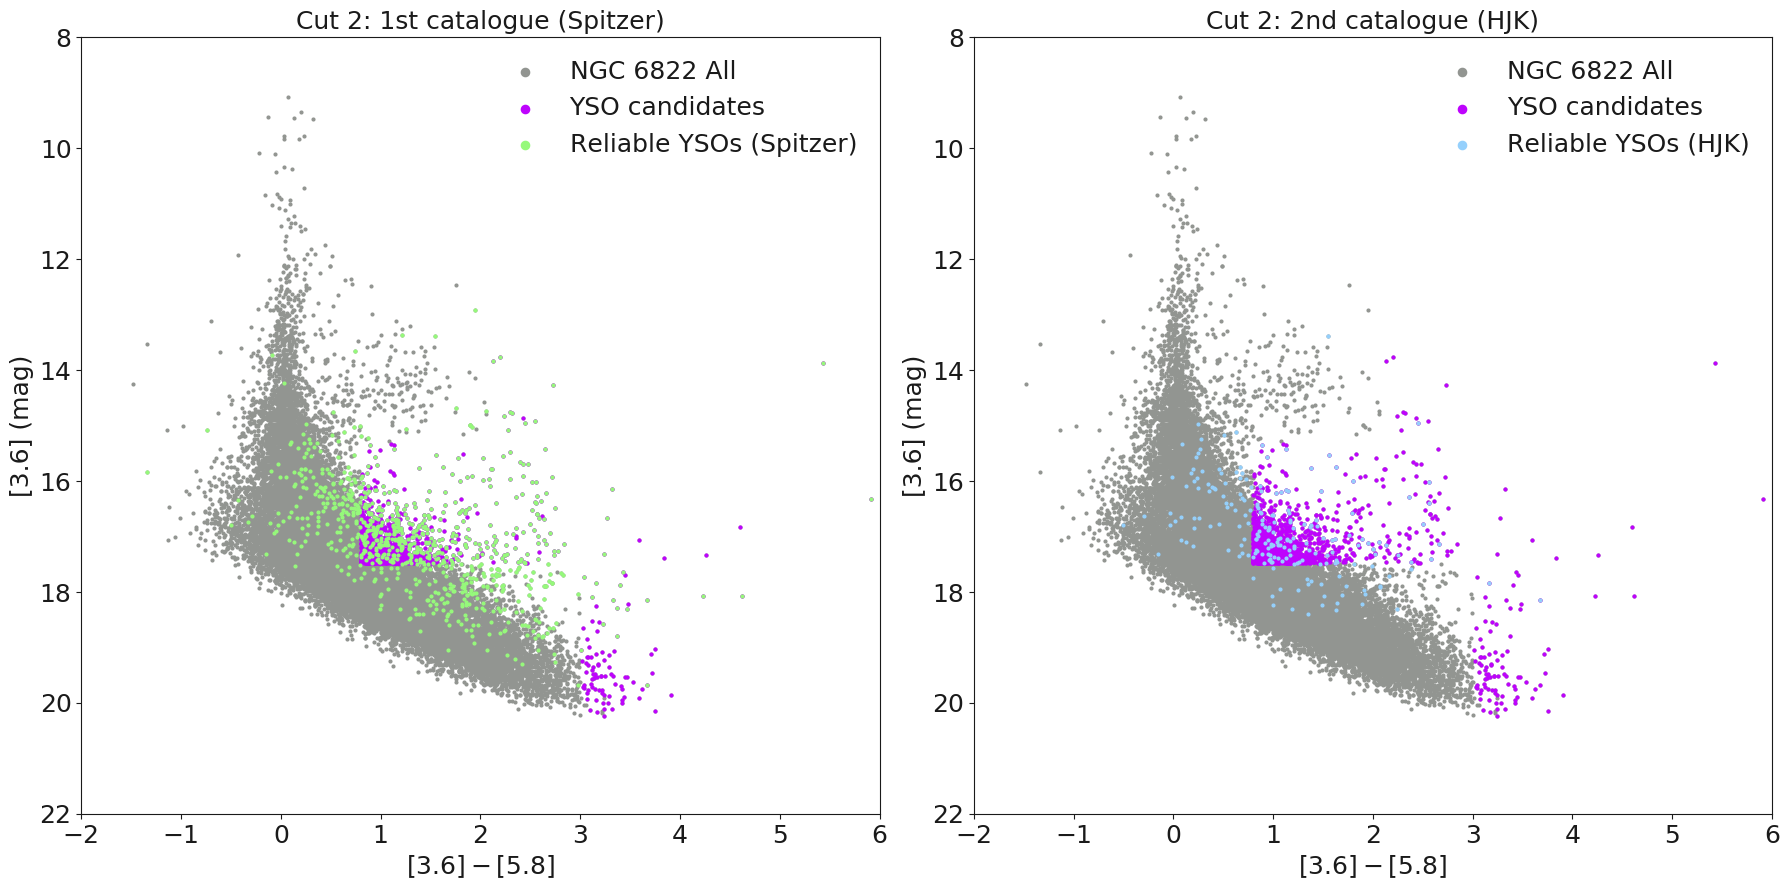

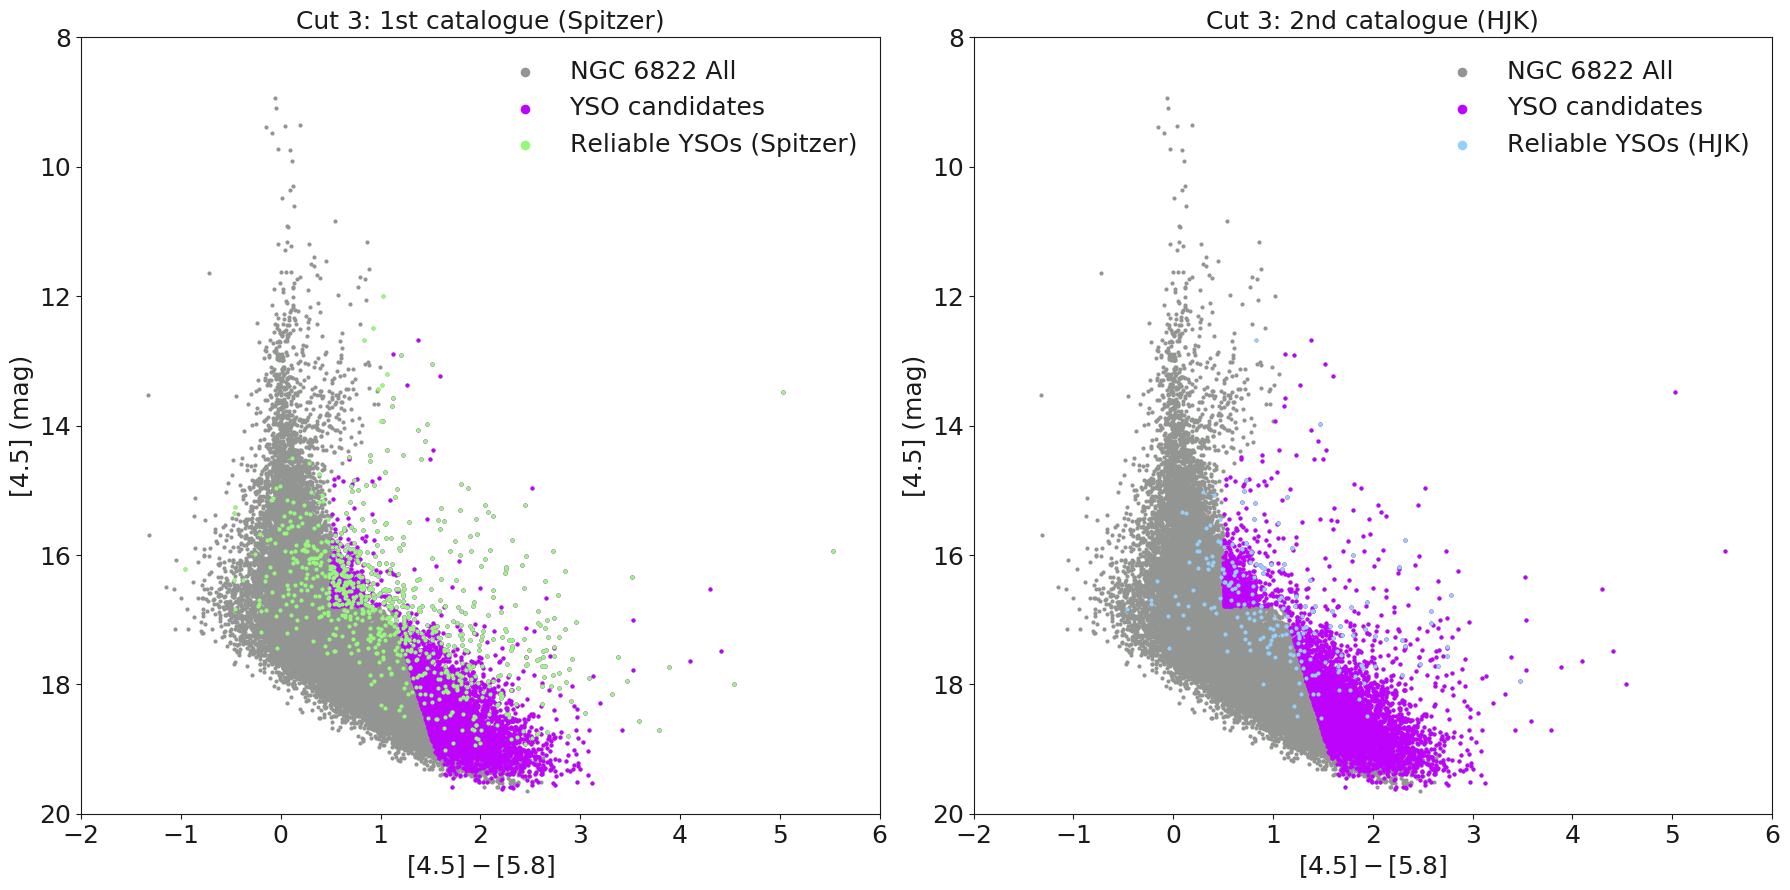

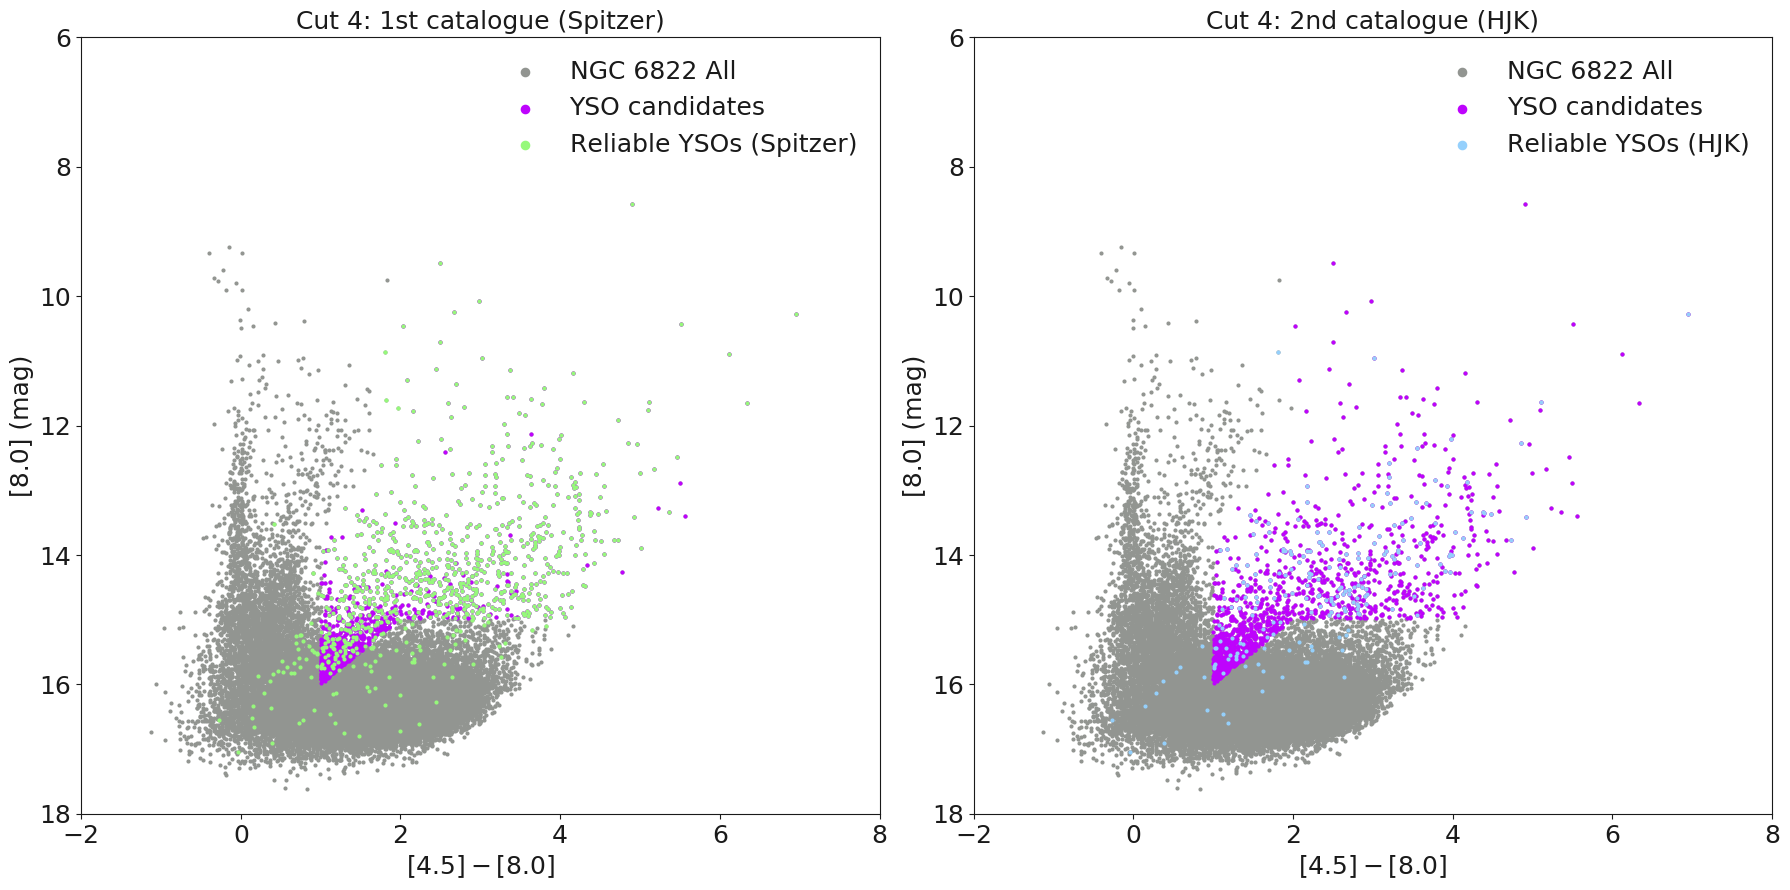

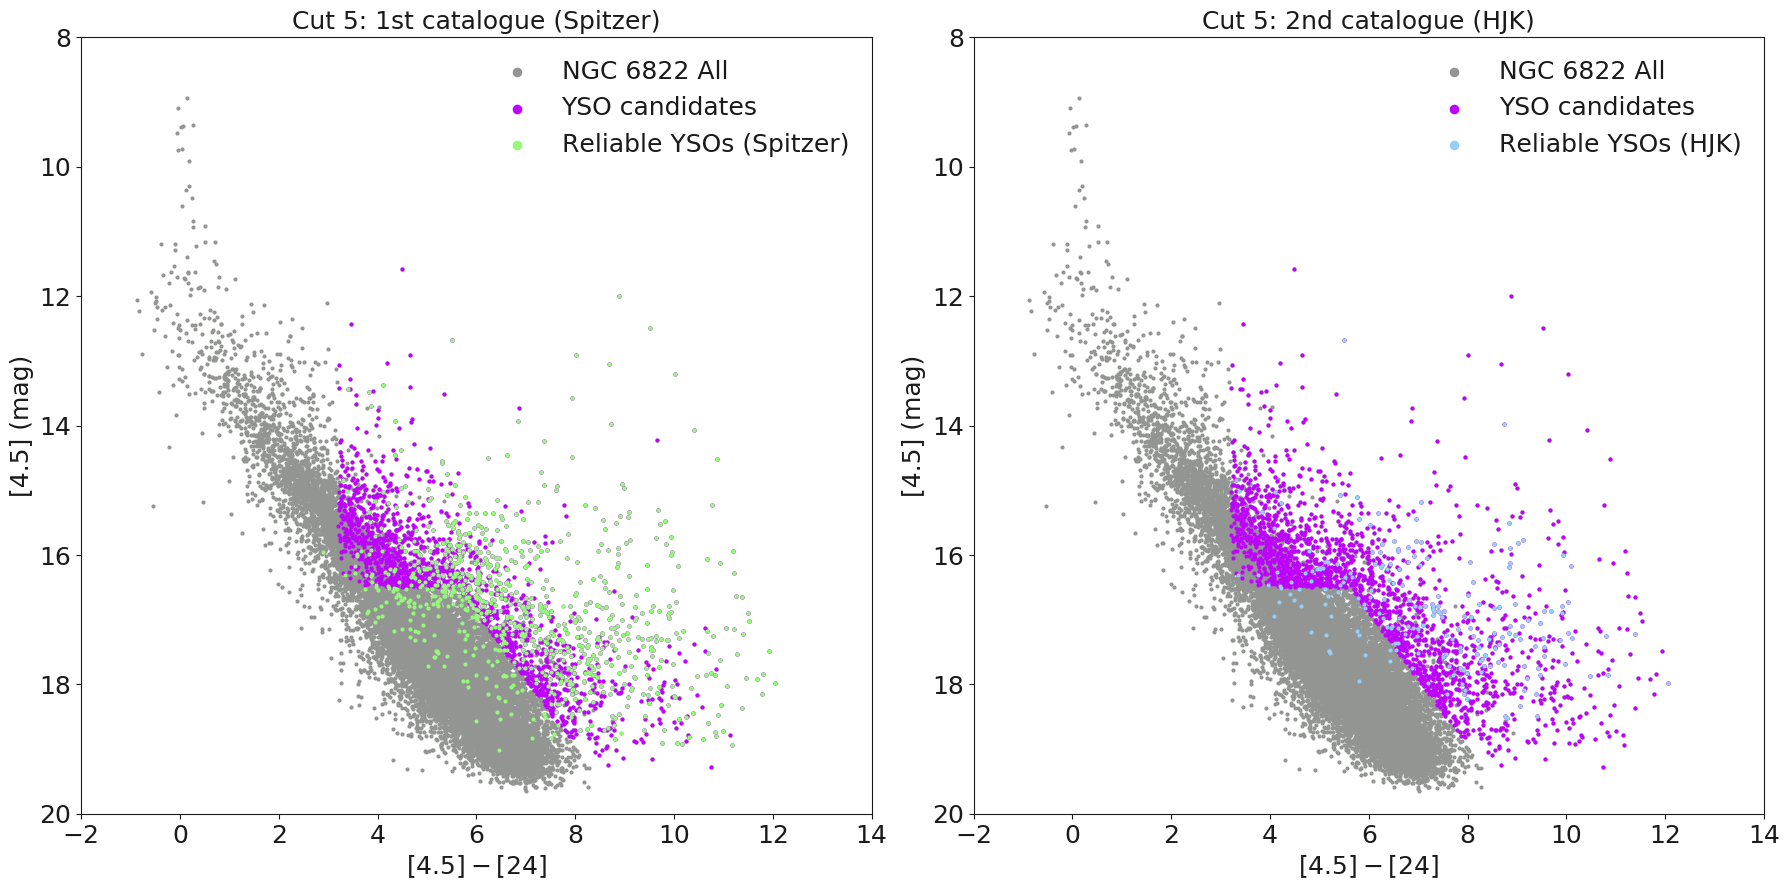

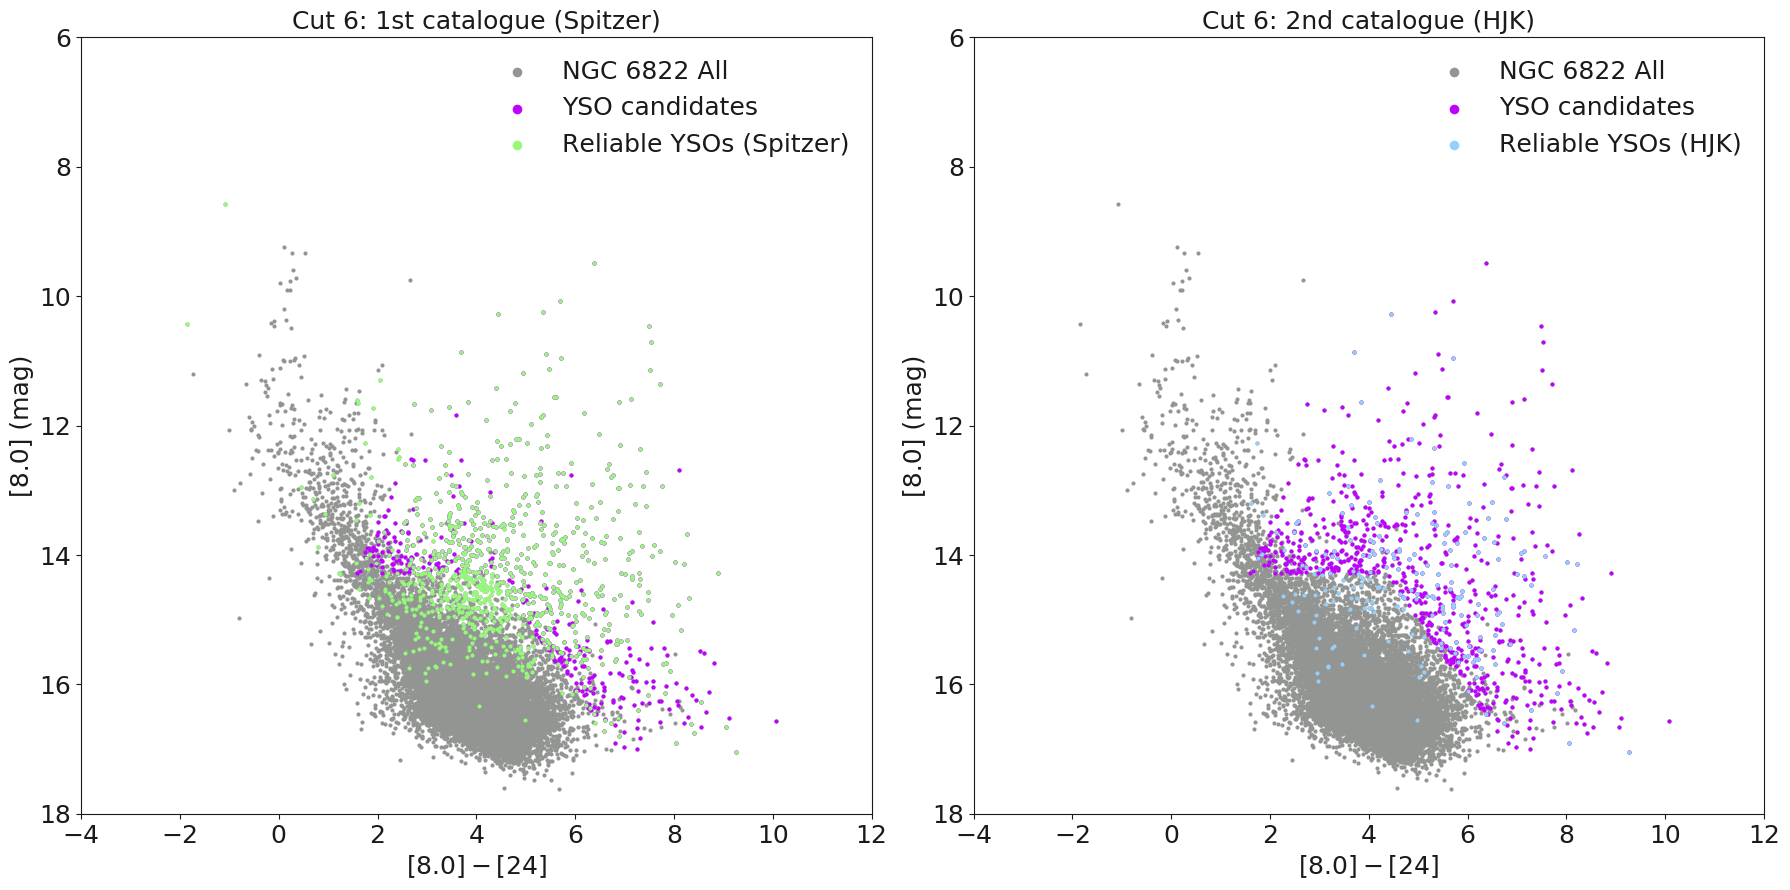

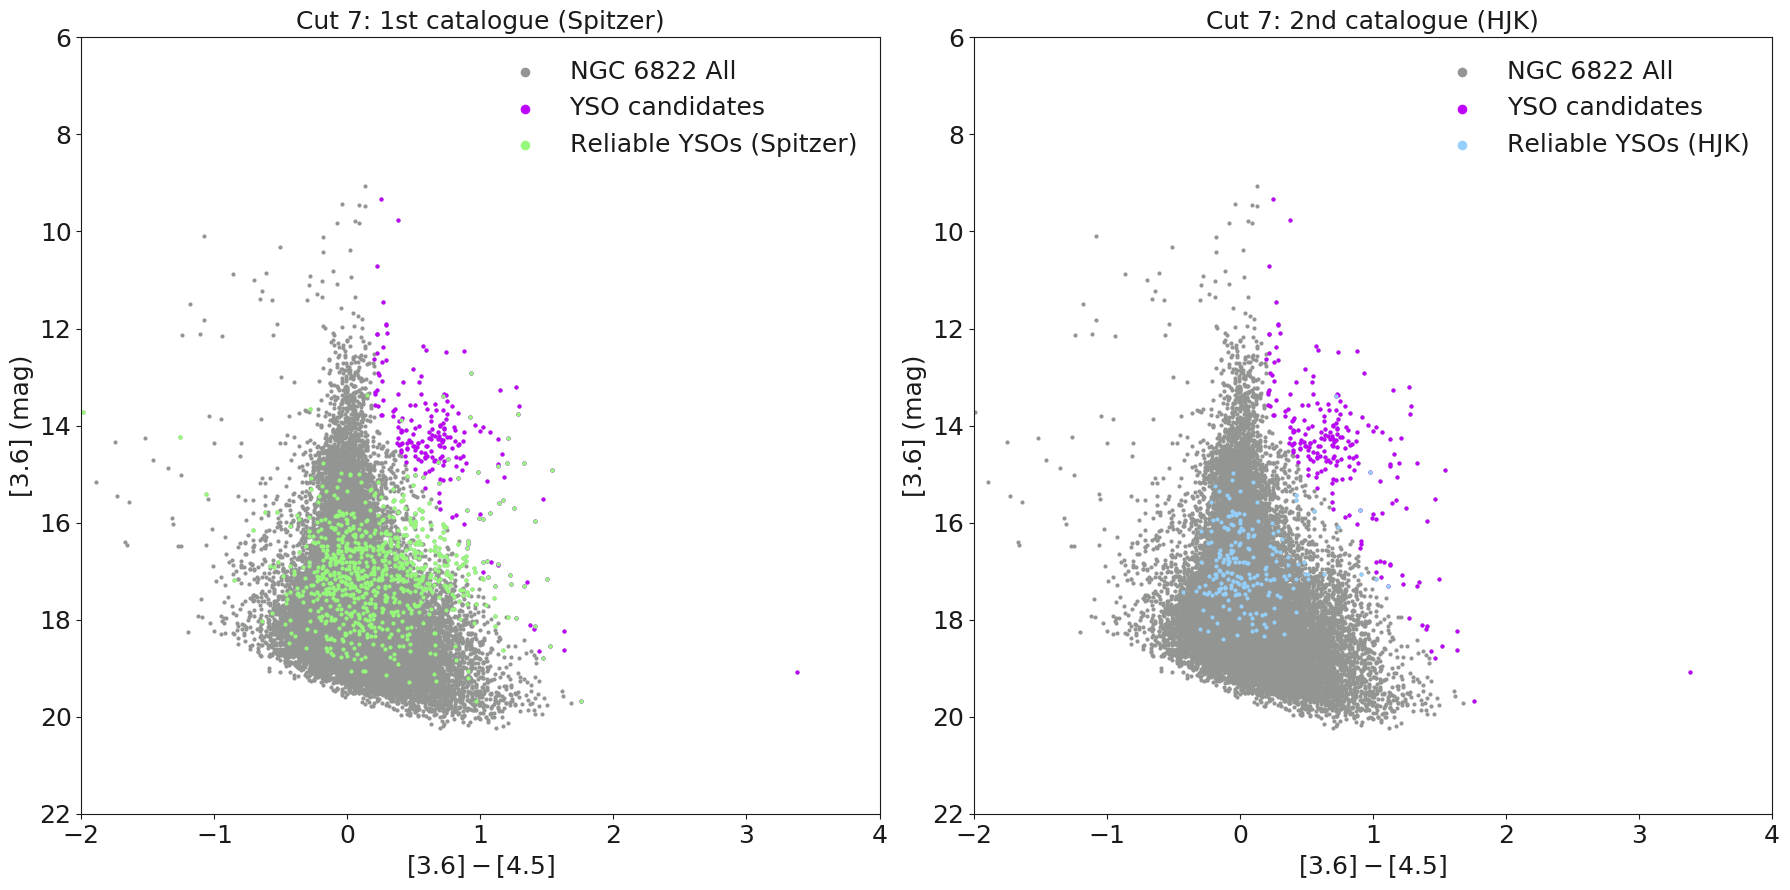

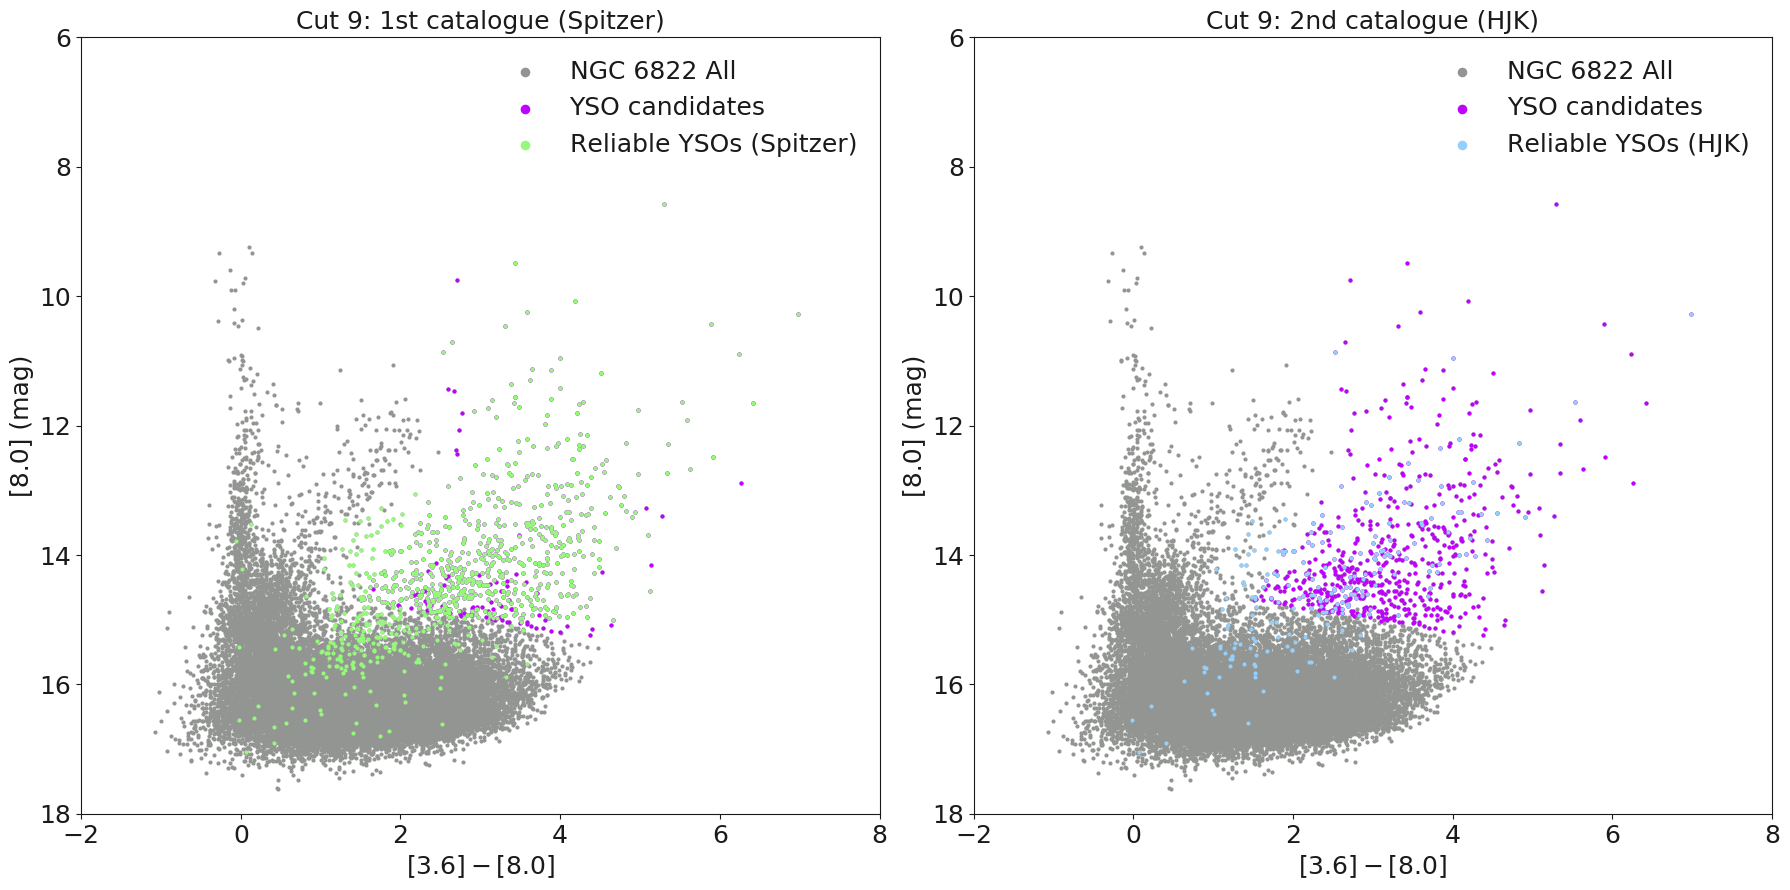

In [148]:
def CMD(A,B,C,all_idx,sp_idx,HJK_idx,num,xlabel,ylabel,xlim,ylim):
    # Setting up plotting sizes
    # plt.rc("text",  usetex=True)         # Allows latex commands
    plt.rcParams.update(plt.rcParamsDefault)       #Keeps the background white
    plt.rc('font', family='sans-serif')
    plt.rc("xtick", labelsize=18)
    plt.rc("ytick", labelsize=18)
    plt.rc("axes", labelsize=18)
    plt.rc("legend", fontsize=18)
    # plt.rcdefaults()                    # Resets the parameters to their default values
    
    # Setting up figure
    plt.figure(figsize=(18,9))
    ax = plt.gca()                        # Sets up active plot region
    
    #Make 1st diagram for 1st reliable catalogue
    plt.subplot(1,2,1)
    # Make the actual plot
    plt.scatter(data[B]-data[C], data[A], s=3.9,color=sns.xkcd_rgb['grey'], label="NGC 6822 All")
    
    # Plot all sensible stars which satify the cut criteria
    plt.scatter(data[B][all_idx]-data[C][all_idx], data[A][all_idx], s=3.9,color=sns.xkcd_rgb['bright purple'], label="YSO candidates")
    # Plot all reliable stars which satify the cut criteria
    plt.scatter(data[B][sp_idx]-data[C][sp_idx], data[A][sp_idx], s=3.9,color=sns.xkcd_rgb['light green'], label="Reliable YSOs (Spitzer)")

    # Set the axis lables
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    
    # Set limits if automatic values dont work well
    plt.xlim(xlim)      # Set the x-axis limits
    plt.ylim(ylim)           # Set the y-axis limits NB Smaller numbers are bighter in magnitudes so flip max/min values

    
    # Add a legend and a title
    plt.legend(loc="upper right",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title('Cut '+num+': 1st catalogue (Spitzer)', fontsize=18)
    
    #Make 2nd diagram for 2nd reliable catalogue
    plt.subplot(1,2,2)
    # Make the actual plot
    plt.scatter(data[B]-data[C], data[A], s=3.9,color=sns.xkcd_rgb['grey'], label="NGC 6822 All")
    
    # Plot all sensible stars which satify the cut criteria
    plt.scatter(data[B][all_idx]-data[C][all_idx], data[A][all_idx], s=3.9,color=sns.xkcd_rgb['bright purple'], label="YSO candidates")
    # Plot all reliable stars which satify the cut criteria
    plt.scatter(data[B][HJK_idx]-data[C][HJK_idx], data[A][HJK_idx], s=3.9,color=sns.xkcd_rgb['light blue'], label="Reliable YSOs (HJK)")
    
    # Set the axis lables
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    
    # Set limits if automatic values dont work well
    plt.xlim(xlim)      # Set the x-axis limits
    plt.ylim(ylim)           # Set the y-axis limits NB Smaller numbers are bighter in magnitudes so flip max/min values

    
    # Add a legend and a title
    plt.legend(loc="upper right",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title('Cut '+num+': 2nd catalogue (HJK)', fontsize=18)
    
    #plt.savefig("bla.pdf", bbox_inches='tight')    # Saves the figure is uncommented
    plt.tight_layout()
    plt.show()
    plt.close()

    
    
CMD('k36mag','k36mag','k58mag',c2_idx,idx_rel_sp_score,idx_rel_HJK_score,'2','$[3.6] -[5.8]$','[3.6] (mag)',(-2,6),(22,8))
CMD('k45mag','k45mag','k58mag',c3_idx,idx_rel_sp_score,idx_rel_HJK_score,'3','$[4.5] -[5.8]$','[4.5] (mag)',(-2,6),(20,8))
CMD('k80mag','k45mag','k80mag',c4_idx,idx_rel_sp_score,idx_rel_HJK_score,'4','$[4.5] -[8.0]$','[8.0] (mag)',(-2,8),(18,6))
CMD('k45mag','k45mag','k24mag',c5_idx,idx_rel_sp_score,idx_rel_HJK_score,'5','$[4.5] -[24]$','[4.5] (mag)',(-2,14),(20,8))
CMD('k80mag','k80mag','k24mag',c6_idx,idx_rel_sp_score,idx_rel_HJK_score,'6','$[8.0] -[24]$','[8.0] (mag)',(-4,12),(18,6))
CMD('k36mag','k36mag','k45mag',c7_idx,idx_rel_sp_score,idx_rel_HJK_score,'7','$[3.6] -[4.5]$','[3.6] (mag)',(-2,4),(22,6))
CMD('k80mag','k36mag','k80mag',c9_idx,idx_rel_sp_score,idx_rel_HJK_score,'9','$[3.6] -[8.0]$','[8.0] (mag)',(-2,8),(18,6))
